[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/alfandoo/churn-portfolio/blob/main/Churn_Prediction.ipynb
)

In [ ]:
# ============================================================
# Customer Churn Prediction — Portfolio
# Author: Alfando | Date: 2025-09-13
# ============================================================
# 🔑 Highlight :
# - CRISP-DM flow: Business → Data Understanding → Prep → Modeling → Evaluation
# - Clean code & reproducibility (RANDOM_STATE, stratified split)
# - Robust EDA (univariate/bivariate/multivariate + chi-square & Cramér’s V)
# - Imbalanced handling (SMOTE in Pipeline)
# - Model benchmarking (LogReg, RF, XGB, SVM, KNN) + GridSearchCV
# - Visual comparison (F1 & ROC-AUC), Confusion Matrix, ROC, PR
# - Exports: results.csv, charts/*.png
# ============================================================

In [16]:
# ======================
# 0. Library & Settings
# ======================
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

from copy import deepcopy

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve,
    precision_recall_curve, confusion_matrix, classification_report
)

from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SkStandardScaler
from pandas.plotting import scatter_matrix

# Reproducibility & display
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (8, 5)
pd.set_option("display.max_columns", 200)

# Create artifact folders
os.makedirs("charts", exist_ok=True)

In [3]:
# ==========================
# 1. Business Understanding
# ==========================
BUSINESS_SUMMARY = """
Subscription-based companies (telecommunications/SaaS) want to reduce customer churn.
Objectives:
1) Predict customers at high risk of churn.
2) Identify churn drivers (tenure, contract, payment type, etc.).
3) Recommend retention strategies based on risk profiles.
"""

print(BUSINESS_SUMMARY.strip())

Subscription-based companies (telecommunications/SaaS) want to reduce customer churn.
Objectives:
1) Predict customers at high risk of churn.
2) Identify churn drivers (tenure, contract, payment type, etc.).
3) Recommend retention strategies based on risk profiles.


In [5]:
# ======================
# 2. Data Understanding
# ======================

DATA_PATH = "/content/customer_churn_data.csv"
TARGET = "Churn"

df = pd.read_csv(DATA_PATH)
print("Original Shape :", df.shape)
display(df.head())
df.info()

Original Shape : (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# --- Minimal cleaning baseline ---
df.drop("customerID", axis=1, inplace=True, errors="ignore")
if "TotalCharges" in df.columns:
    df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan)
    df["TotalCharges"] = df["TotalCharges"].astype("float64")

print("\nNumber of missing values per column:")
print(df.isna().sum().sort_values(ascending=False))

print("\nNumber of duplicates:", df.duplicated().sum())


Number of missing values per column:
TotalCharges        11
gender               0
Partner              0
SeniorCitizen        0
Dependents           0
tenure               0
MultipleLines        0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
InternetService      0
TechSupport          0
StreamingTV          0
Contract             0
StreamingMovies      0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
Churn                0
dtype: int64

Number of duplicates: 22


In [7]:
# drop NA & duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print("\nAfter minimum cleaning:")
print("Missing total:", int(df.isna().sum().sum()))
print("Duplicate:", df.duplicated().sum())
print("Shape:", df.shape)


After minimum cleaning:
Missing total: 0
Duplicate: 0
Shape: (7010, 20)


In [9]:
# Target flag (0/1) for numerical analysis
assert TARGET in df.columns, "The ‘Churn’ column was not found."
df["ChurnFlag"] = df[TARGET].map({"Yes": 1, "No": 0})

In [10]:
# Feature types
num_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = df.select_dtypes(include=["object"]).columns.tolist()
if "ChurnFlag" in num_features:
    num_features = [c for c in num_features if c != "ChurnFlag"]

print("\nNumeric features:", num_features[:10])
print("Categorical features :", cat_features[:10])


Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features : ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']


In [11]:
# -----------------------
# 2.1 Descriptive Stats
# -----------------------
print("\nNumerical summary:")
display(df.describe().T)


Numerical summary:


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7010.0,0.162767,0.369180,0.00,0.0000,0.000,0.0000,1.00
tenure,7010.0,32.520399,24.520441,1.00,9.0000,29.000,56.0000,72.00
MonthlyCharges,7010.0,64.888666,30.064769,18.25,35.7500,70.400,89.9000,118.75
TotalCharges,7010.0,2290.353388,2266.820832,18.80,408.3125,1403.875,3807.8375,8684.80
ChurnFlag,7010.0,0.264907,0.441315,0.00,0.0000,0.000,1.0000,1.00


In [12]:
print("\nDistribution of categorical variables:")
for col in cat_features:
    print(f"\n{col}:")
    print(df[col].value_counts().head(10))


Distribution of categorical variables:

gender:
gender
Male      3535
Female    3475
Name: count, dtype: int64

Partner:
Partner
No     3617
Yes    3393
Name: count, dtype: int64

Dependents:
Dependents
No     4911
Yes    2099
Name: count, dtype: int64

PhoneService:
PhoneService
Yes    6330
No      680
Name: count, dtype: int64

MultipleLines:
MultipleLines
No                  3363
Yes                 2967
No phone service     680
Name: count, dtype: int64

InternetService:
InternetService
Fiber optic    3090
DSL            2414
No             1506
Name: count, dtype: int64

OnlineSecurity:
OnlineSecurity
No                     3489
Yes                    2015
No internet service    1506
Name: count, dtype: int64

OnlineBackup:
OnlineBackup
No                     3079
Yes                    2425
No internet service    1506
Name: count, dtype: int64

DeviceProtection:
DeviceProtection
No                     3086
Yes                    2418
No internet service    1506
Name: count, dtyp

In [13]:
print("\nMode for each column:")
for col in df.columns:
    mode_val = df[col].mode().iloc[0]
    print(f"- {col}: {mode_val}")


Mode for each column:
- gender: Male
- SeniorCitizen: 0
- Partner: No
- Dependents: No
- tenure: 1
- PhoneService: Yes
- MultipleLines: No
- InternetService: Fiber optic
- OnlineSecurity: No
- OnlineBackup: No
- DeviceProtection: No
- TechSupport: No
- StreamingTV: No
- StreamingMovies: No
- Contract: Month-to-month
- PaperlessBilling: Yes
- PaymentMethod: Electronic check
- MonthlyCharges: 20.05
- TotalCharges: 19.75
- Churn: No
- ChurnFlag: 0


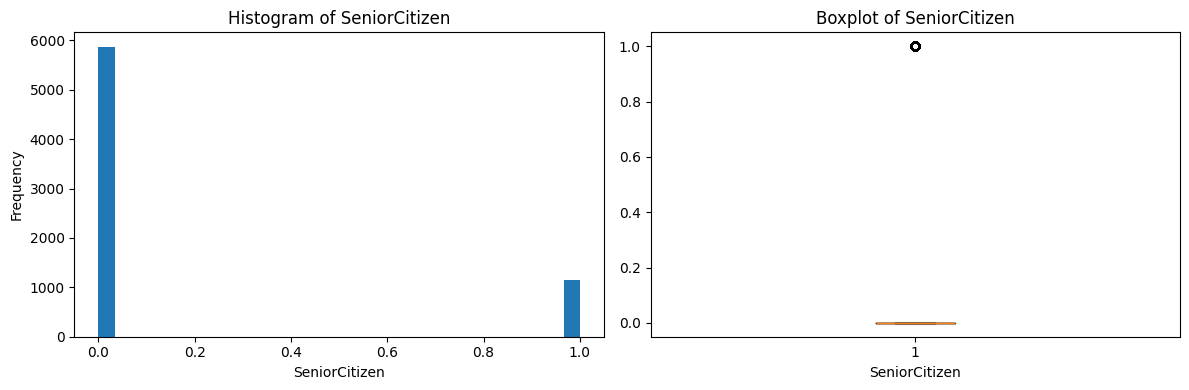

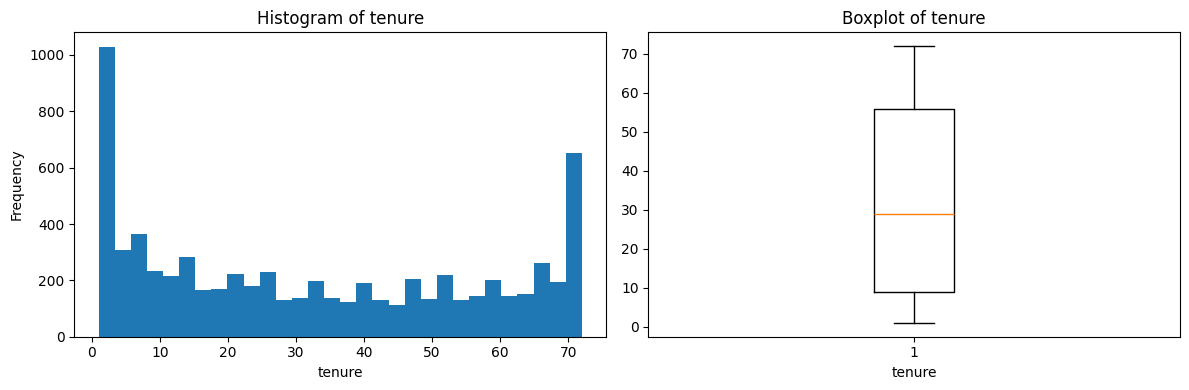

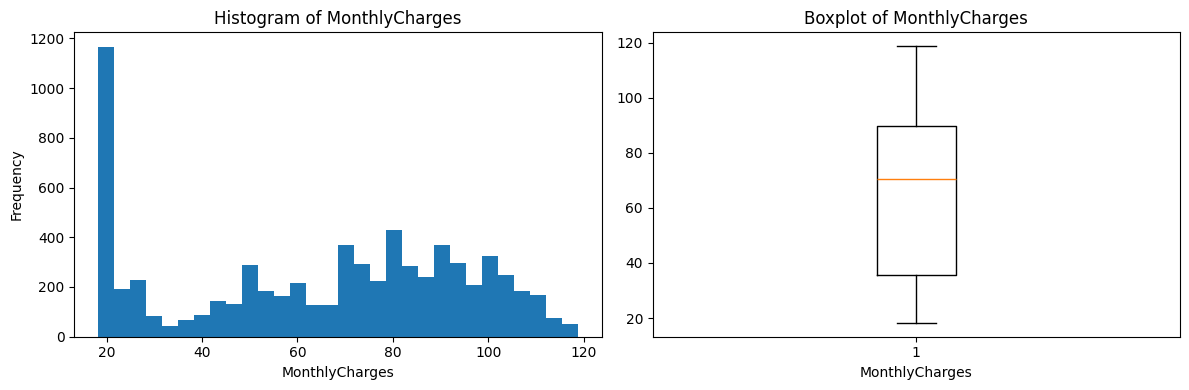

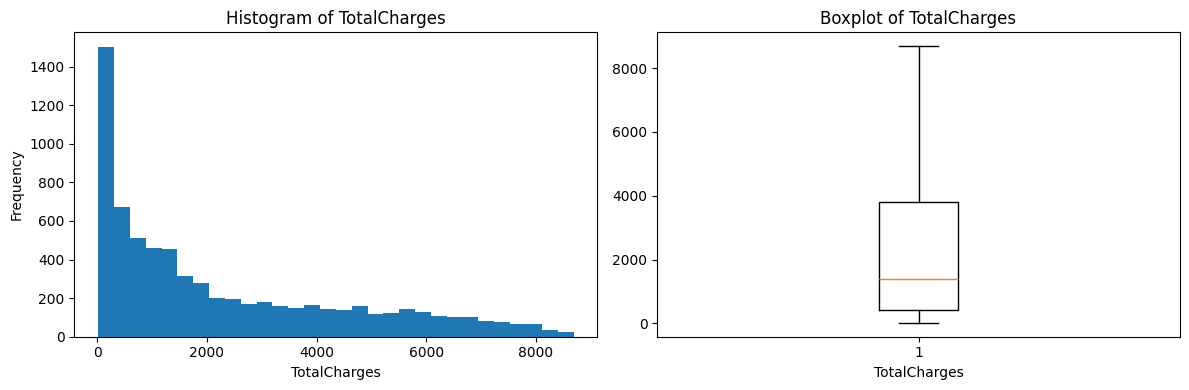

In [14]:
# ==============================
# 3. EDA — Visual (Univariate)
# ==============================
def save_fig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.show()

# Numeric → histogram & boxplot
for col in num_features:
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    df[col].plot(kind="hist", bins=30, title=f"Histogram of {col}")
    plt.xlabel(col)
    plt.subplot(1,2,2)
    plt.boxplot(df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    save_fig(f"charts/univariate_{col}.png")

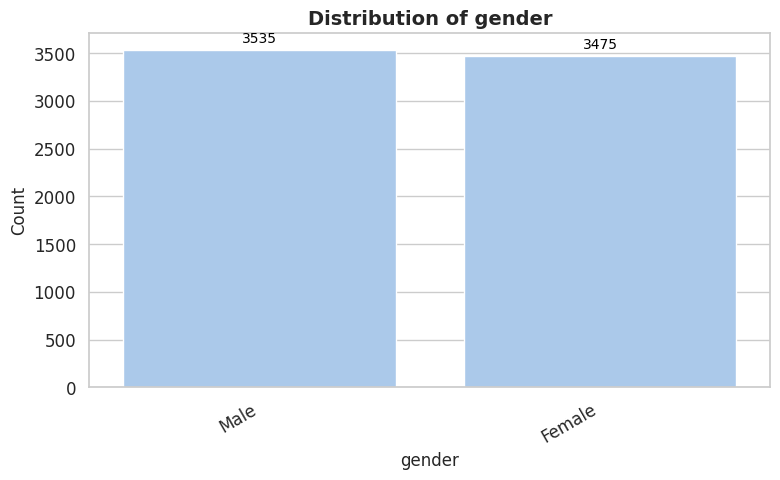

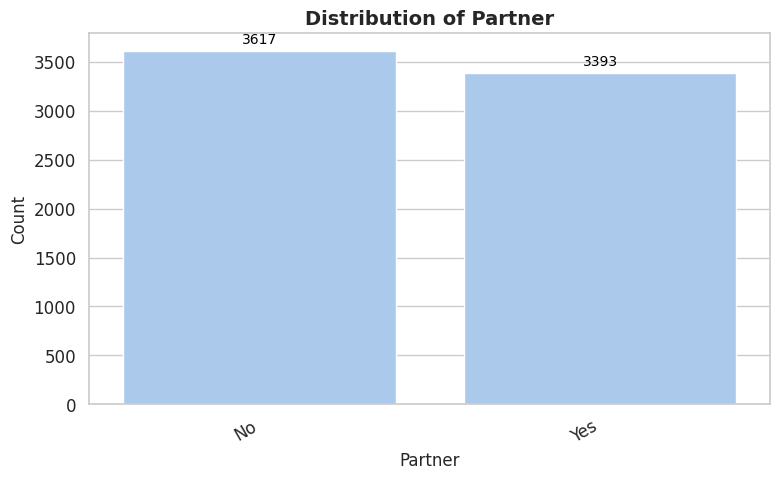

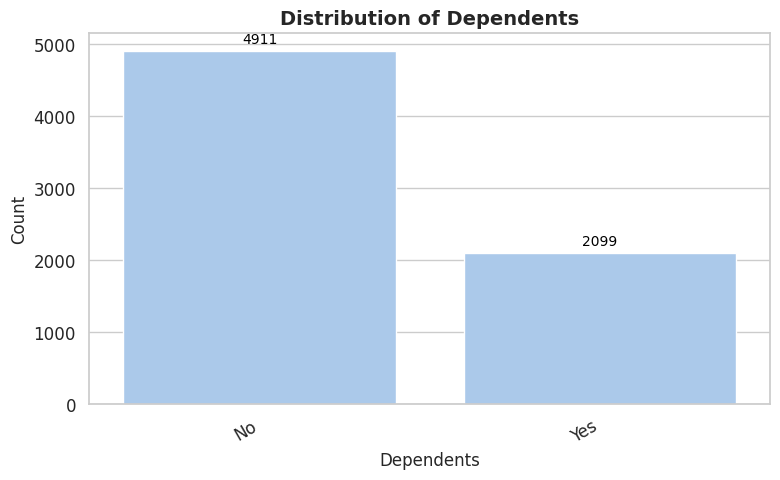

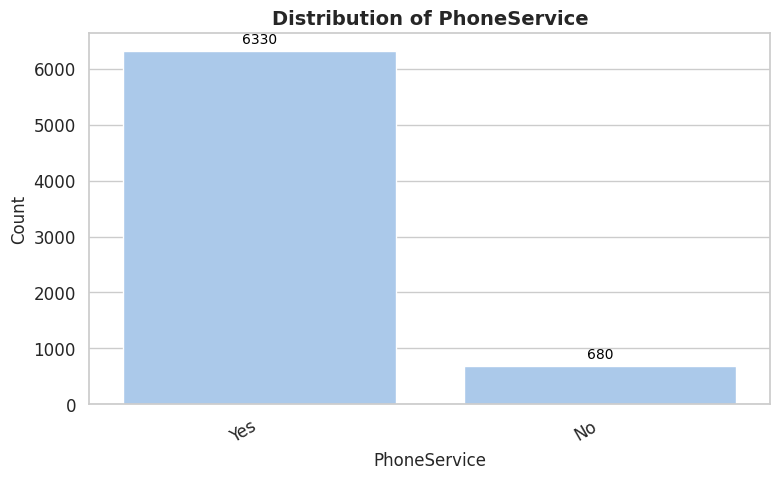

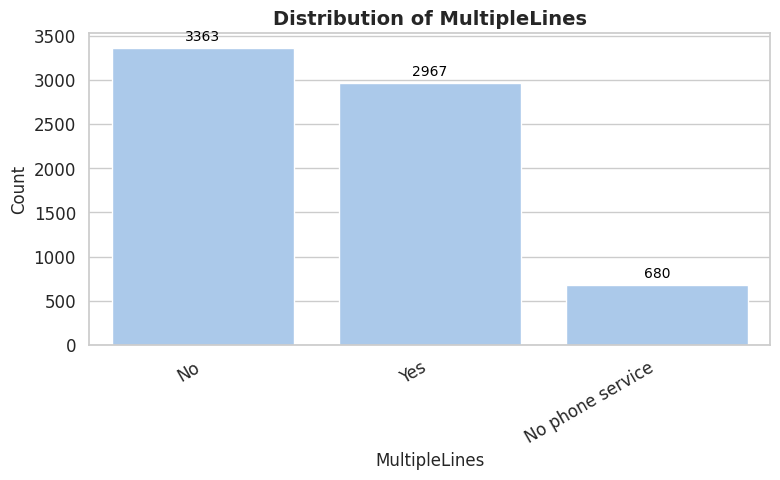

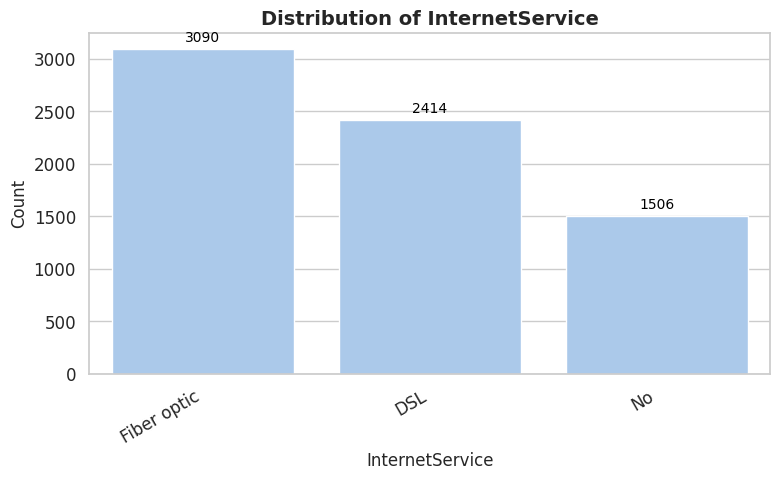

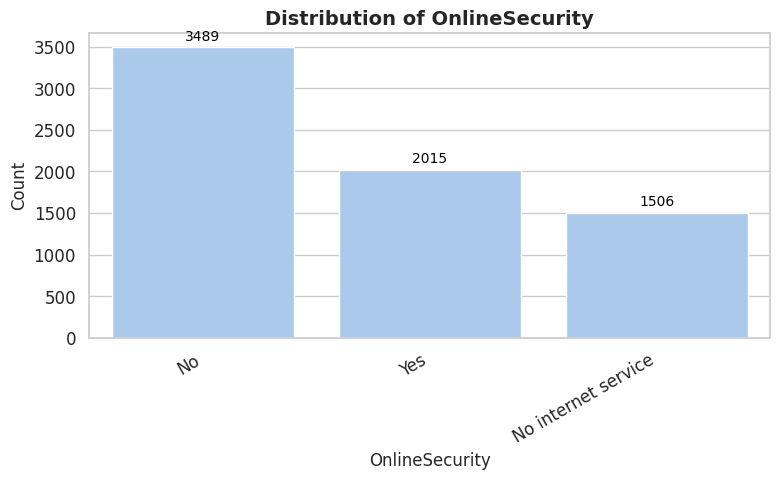

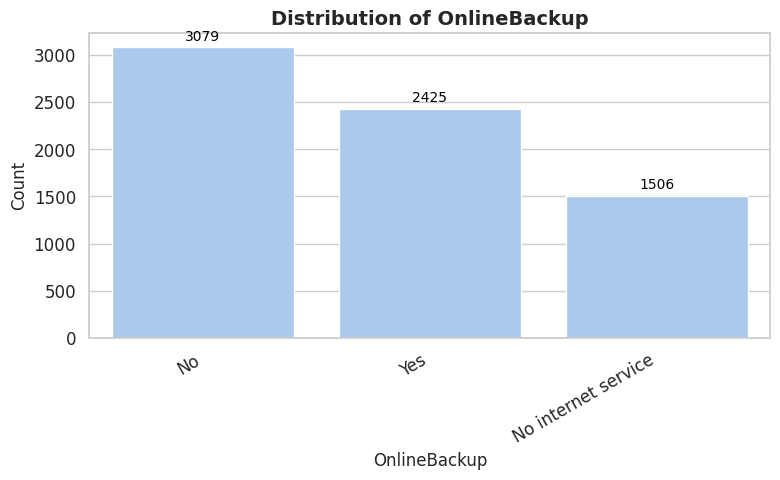

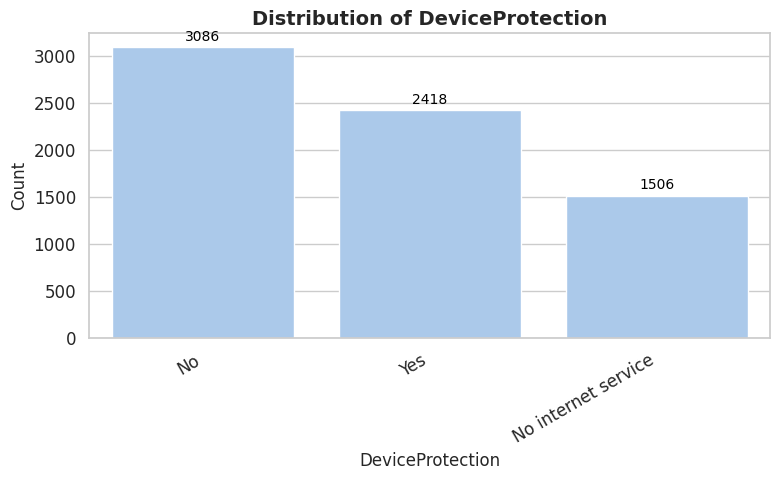

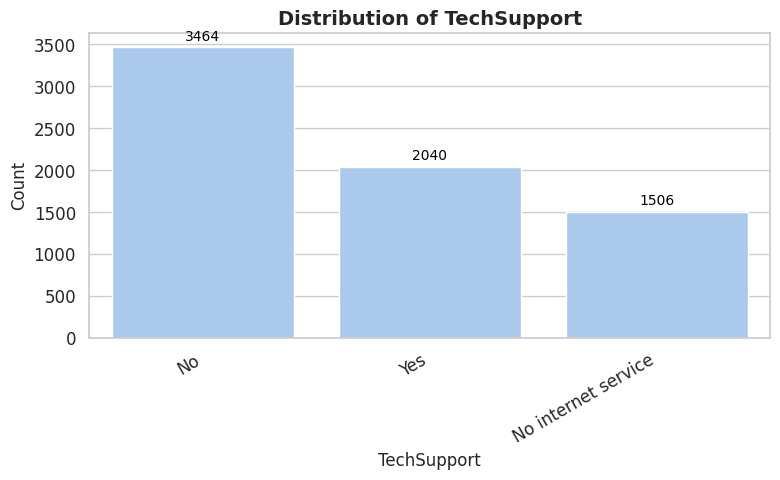

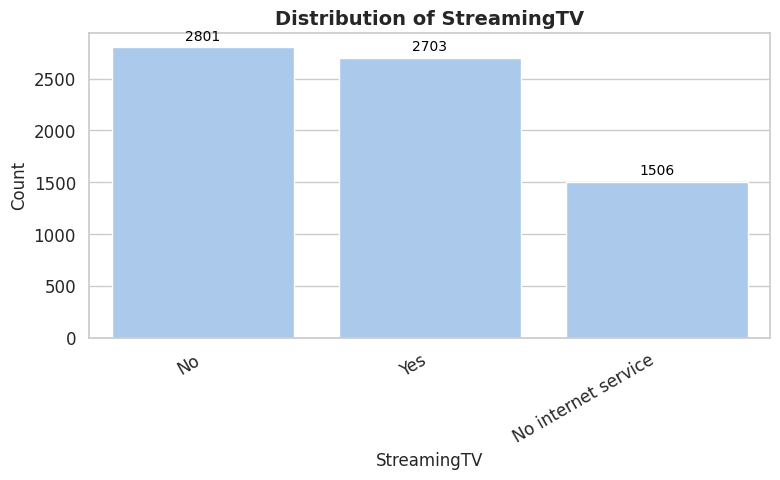

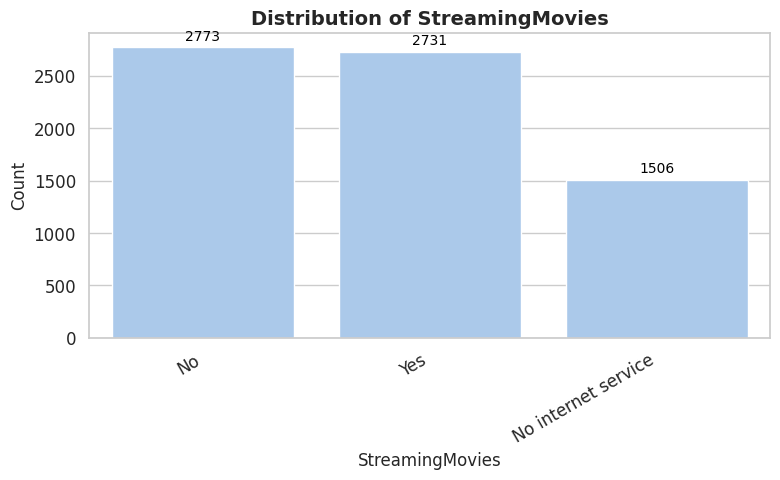

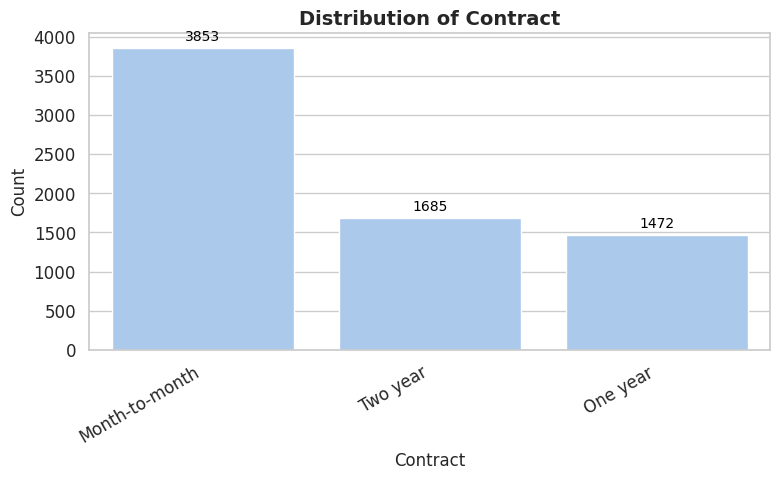

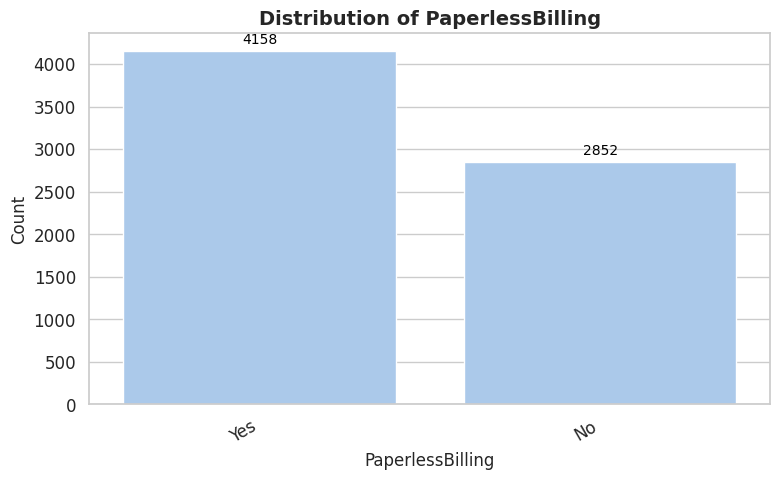

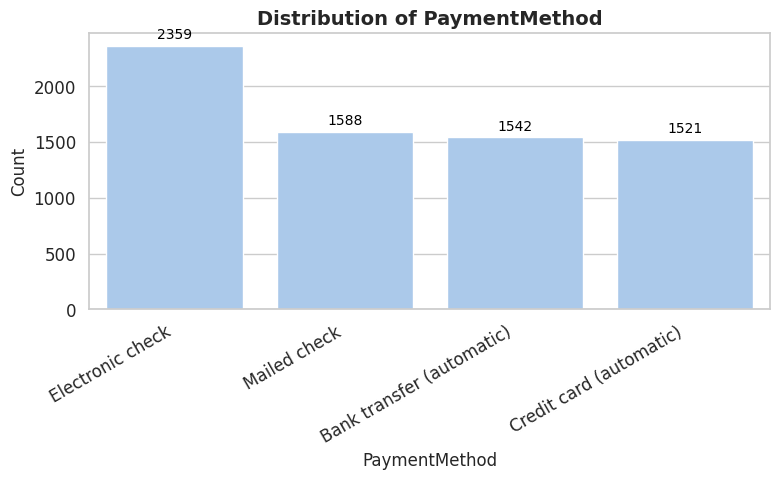

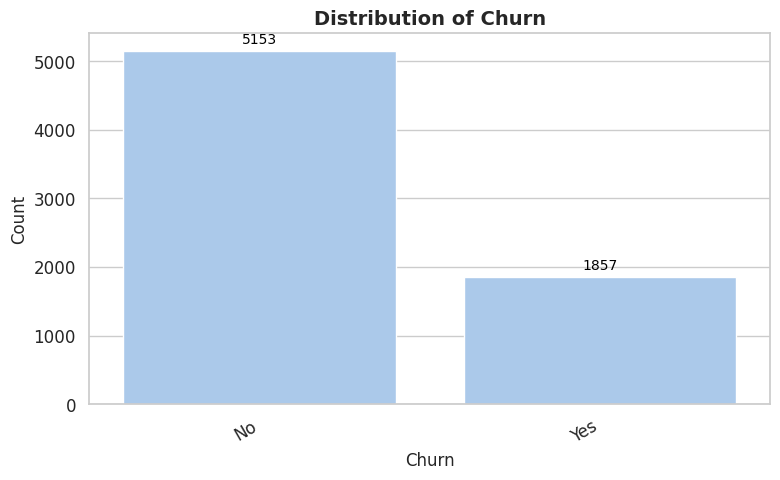

In [17]:
# Categorical → bar chart

def plot_categorical_bars(df, cat_features):
    for col in cat_features:
        plt.figure(figsize=(8, 5))
        ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index)

        # title & label
        plt.title(f"Distribution of {col}", fontsize=14, weight="bold")
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)

        # rotate the label if it is long
        plt.xticks(rotation=30, ha="right")

        # annotation of values above the bar
        for p in ax.patches:
            ax.annotate(
                f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color="black", xytext=(0, 3),
                textcoords="offset points"
            )

        plt.tight_layout()
        save_fig(f"charts/univariate_{col}_bar.png")  # auto save
        plt.show()

# Call the function
plot_categorical_bars(df, cat_features)

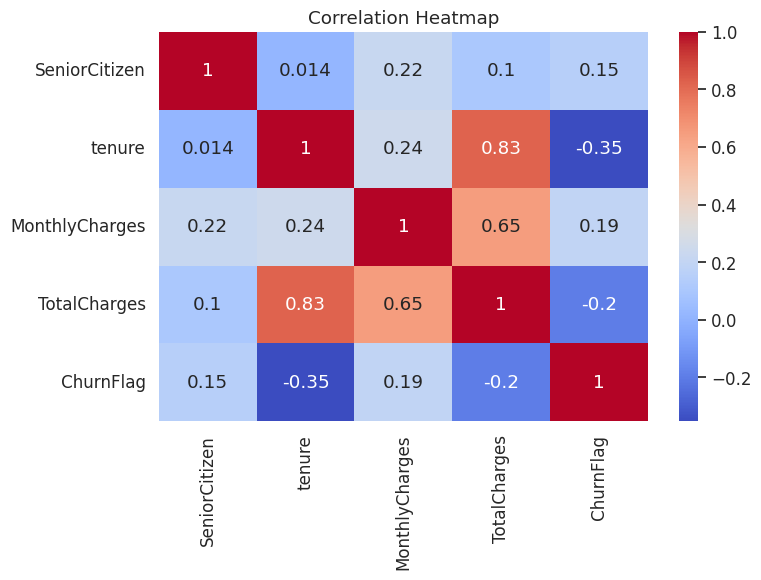

In [18]:
# ===============================
# 4. EDA — Bivariate/Multivariate
# ===============================
# 4.1 Numerical correlation
plt.figure(figsize=(8,6))
sns.heatmap(df[num_features + ["ChurnFlag"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
save_fig("charts/corr_heatmap.png")

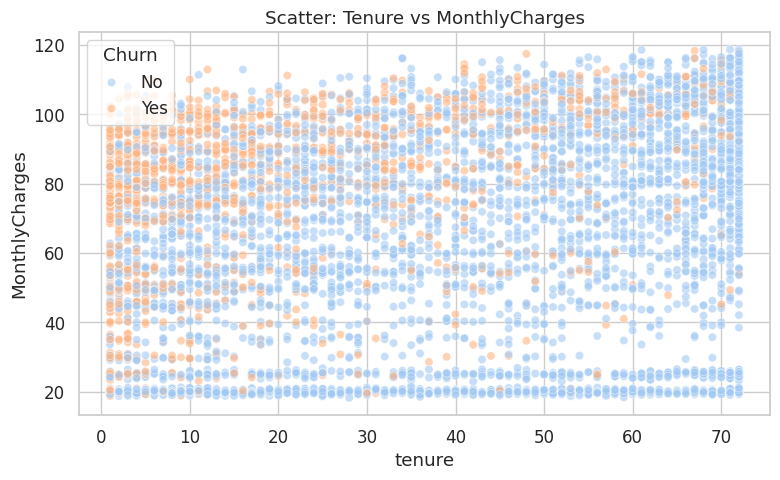

In [19]:
# 4.2 Scatterplot
sns.scatterplot(x="tenure", y="MonthlyCharges", hue="Churn", data=df, alpha=0.6)
plt.title("Scatter: Tenure vs MonthlyCharges")
save_fig("charts/scatter_tenure_monthly.png")

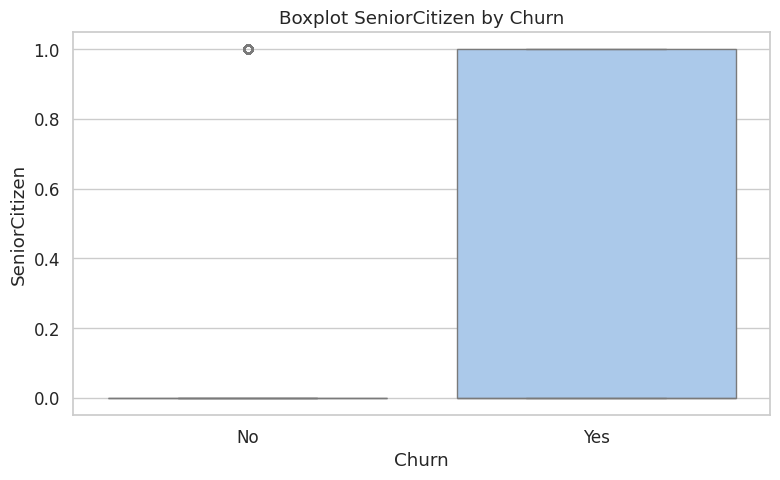

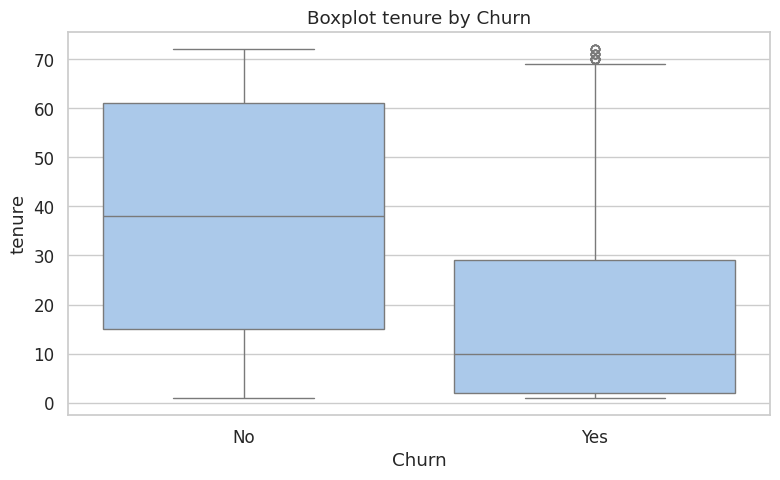

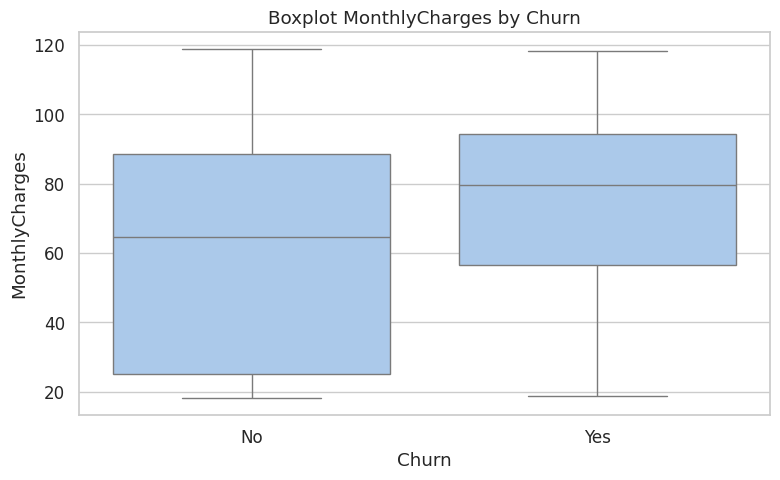

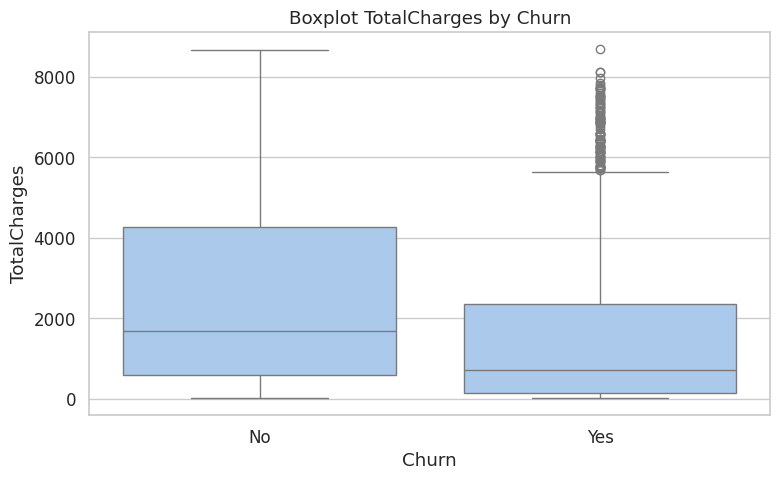

In [20]:
# 4.3 Boxplot numeric vs. churn
for col in num_features:
    plt.figure()
    sns.boxplot(x="Churn", y=col, data=df)
    plt.title(f"Boxplot {col} by Churn")
    save_fig(f"charts/box_{col}_by_churn.png")


In [22]:
# 4.4 Chi-square & Cramér’s V
def interpret_p(p):
    if p < 0.001: return "Very Significant (***, p<0.001)"
    elif p < 0.01: return "Significant (**, p<0.01)"
    elif p < 0.05: return "Significant (*, p<0.05)"
    else: return "Not Significant (p≥0.05)"

def interpret_v(v):
    if v < 0.1: return "Very weak (≈0–0.1)"
    elif v < 0.3: return "Weak (0.1–0.3)"
    elif v < 0.5: return "Medium (0.3–0.5)"
    else: return "Strong (≥0.5)"

chi_results = []
for col in cat_features:
    if col == TARGET:
        continue
    ct = pd.crosstab(df[col], df[TARGET])
    if ct.shape[0] < 2 or ct.shape[1] < 2:
        continue
    chi2, p, dof, exp = chi2_contingency(ct)
    n = ct.values.sum()
    # V bias-corrected
    phi2 = chi2 / n
    r, k = ct.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    v = np.sqrt(phi2corr / max((kcorr-1), (rcorr-1)))
    chi_results.append([col, chi2, p, interpret_p(p), v, interpret_v(v), int(n), int(dof)])

chi_df = pd.DataFrame(
    chi_results,
    columns=["Feature","Chi2","p_value","p_interpretation","Cramers_V","V_strength","N","dof"]
).sort_values(["Cramers_V","Chi2"], ascending=False)

print("\nTop Categorical vs. Churn (Cramér’s V):")
display(chi_df.head(15))


Top Categorical vs. Churn (Cramér’s V):


,Feature,Chi2,p_value,p_interpretation,Cramers_V,V_strength,N,dof
12,Contract,1174.768423,7.985062e-256,"Very Significant (***, p<0.001)",0.289264,Weak (0.1–0.3),7010,2
6,OnlineSecurity,843.465432,6.979249e-184,"Very Significant (***, p<0.001)",0.245023,Weak (0.1–0.3),7010,2
9,TechSupport,821.730805,3.659509e-179,"Very Significant (***, p<0.001)",0.241837,Weak (0.1–0.3),7010,2
5,InternetService,728.444401,6.611624e-159,"Very Significant (***, p<0.001)",0.227661,Weak (0.1–0.3),7010,2
7,OnlineBackup,596.338880,3.211128e-130,"Very Significant (***, p<0.001)",0.205923,Weak (0.1–0.3),7010,2
8,DeviceProtection,553.351497,6.938237e-121,"Very Significant (***, p<0.001)",0.198336,Weak (0.1–0.3),7010,2
13,PaperlessBilling,253.565649,4.336282e-57,"Very Significant (***, p<0.001)",0.189827,Weak (0.1–0.3),7010,1
14,PaymentMethod,641.203926,1.176117e-138,"Very Significant (***, p<0.001)",0.174242,Weak (0.1–0.3),7010,3
11,StreamingMovies,374.194319,5.555666e-82,"Very Significant (***, p<0.001)",0.162957,Weak (0.1–0.3),7010,2
10,StreamingTV,372.484023,1.306538e-81,"Very Significant (***, p<0.001)",0.162582,Weak (0.1–0.3),7010,2


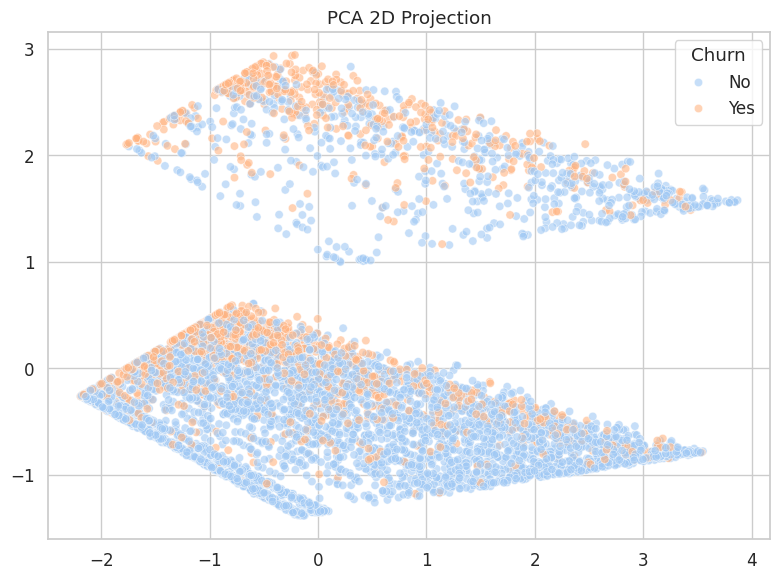

In [23]:
# 4.5 Multivariat (Scatter Matrix & PCA)
if len(num_features) >= 5:
    scatter_matrix(df[num_features[:5]], figsize=(10,10), diagonal="hist")
    save_fig("charts/scatter_matrix_top5.png")

if len(num_features) >= 2:
    scaler = SkStandardScaler()
    X_scaled = scaler.fit_transform(df[num_features])
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["Churn"], alpha=0.6)
    plt.title("PCA 2D Projection")
    save_fig("charts/pca_2d.png")

In [24]:
# 4.6 Outlier (Z-score)
from scipy.stats import zscore
outlier_summary = {col: int((np.abs(zscore(df[col])) > 3).sum()) for col in num_features}
print("\nNumber of outliers (|z| > 3) per numeric:")
print(outlier_summary)


Number of outliers (|z| > 3) per numeric:
{'SeniorCitizen': 0, 'tenure': 0, 'MonthlyCharges': 0, 'TotalCharges': 0}


In [25]:
# 4.7 Initial insight
print("\n=== Initial EDA Insight ===")
print(f"- Overall churn rate: {df['ChurnFlag'].mean():.2%}")
if "Contract" in df.columns:
    print("\nChurn rate per Contract:")
    print(df.groupby("Contract")["ChurnFlag"].mean().sort_values(ascending=False))
if "tenure" in df.columns:
    print("\nAverage tenure per churn:")
    print(df.groupby("Churn")["tenure"].mean())
if "MonthlyCharges" in df.columns:
    print("\nAverage Monthly Charges per churn:")
    print(df.groupby("Churn")["MonthlyCharges"].mean())

print("\nTop numerical correlation with ChurnFlag:")
print(df[num_features + ["ChurnFlag"]].corr()["ChurnFlag"].sort_values(ascending=False))

print("\nTop 5 most related categorical features (Cramér’s V):")
print(chi_df[["Feature","Cramers_V","V_strength","p_interpretation"]].head(5).to_string(index=False))



=== Initial EDA Insight ===
- Overall churn rate: 26.49%

Churn rate per Contract:
Contract
Month-to-month    0.426421
One year          0.112772
Two year          0.028487
Name: ChurnFlag, dtype: float64

Average tenure per churn:
Churn
No     37.721133
Yes    18.088853
Name: tenure, dtype: float64

Average Monthly Charges per churn:
Churn
No     61.387415
Yes    74.604308
Name: MonthlyCharges, dtype: float64

Top numerical correlation with ChurnFlag:
ChurnFlag         1.000000
MonthlyCharges    0.194008
SeniorCitizen     0.151270
TotalCharges     -0.198362
tenure           -0.353339
Name: ChurnFlag, dtype: float64

Top 5 most related categorical features (Cramér’s V):
        Feature  Cramers_V     V_strength                p_interpretation
       Contract   0.289264 Weak (0.1–0.3) Very Significant (***, p<0.001)
 OnlineSecurity   0.245023 Weak (0.1–0.3) Very Significant (***, p<0.001)
    TechSupport   0.241837 Weak (0.1–0.3) Very Significant (***, p<0.001)
InternetService   0.2276

In [26]:
# ===================
# 5. Data Preparation
# ===================
X = df.drop(columns=[TARGET, "ChurnFlag"])
y = df["ChurnFlag"]

In [27]:
num_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric features:", num_features)
print("Categorical features:", cat_features)


Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [28]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("\nTrain:", X_train.shape, " Test:", X_test.shape)
print("Class balance (train):", dict(zip(*np.unique(y_train, return_counts=True))))


Train: (5608, 19)  Test: (1402, 19)
Class balance (train): {np.int64(0): np.int64(4122), np.int64(1): np.int64(1486)}


In [46]:
# ==================
# 6. Model Benchmark
# ==================
models = {
    "LogisticRegression": (
        LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE),
        {
            "classifier__C": [0.01, 0.1, 1, 10],
            "classifier__solver": ["liblinear", "lbfgs"]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
        {
            "classifier__n_estimators": [200, 400],
            "classifier__max_depth": [5, 10, None],
            "classifier__min_samples_split": [2, 5]
        }
    ),
    "XGBoost": (
        XGBClassifier(
            eval_metric="logloss", use_label_encoder=False, random_state=RANDOM_STATE,
            scale_pos_weight=1.0  # class_weight alternative handled by SMOTE
        ),
        {
            "classifier__n_estimators": [200, 400],
            "classifier__max_depth": [3, 5, 7],
            "classifier__learning_rate": [0.03, 0.1],
            "classifier__subsample": [0.8, 1.0],
            "classifier__colsample_bytree": [0.8, 1.0]
        }
    ),
    "SVC": (
        SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE),
        {
            "classifier__C": [0.3, 1, 3],
            "classifier__kernel": ["linear", "rbf"],
            "classifier__gamma": ["scale", "auto"]
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "classifier__n_neighbors": [5, 7, 9, 11],
            "classifier__weights": ["uniform", "distance"]
        }
    )
}

In [47]:
def fit_and_score(model_name, model, param_grid):
    """
    Build pipeline: Preprocess -> SMOTE -> Classifier
    Use F1 as main scoring (imbalance), 3-fold CV
    """
    pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("classifier", model)
    ])
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="f1",
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)[:,1]

    return {
        "Model": model_name,
        "Best_Estimator": best,
        "Best_Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "AP": average_precision_score(y_test, y_proba)  # area under PR curve
    }

results = []
best_objects = {}

for name, (mdl, grid_params) in models.items():
    print(f"\n=== Training {name} ===")
    out = fit_and_score(name, mdl, grid_params)
    results.append({k: v for k, v in out.items() if k not in ["Best_Estimator"]})
    best_objects[name] = out["Best_Estimator"]

results_df = pd.DataFrame(results).sort_values(["F1", "ROC-AUC"], ascending=False)
display(results_df)

results_df.to_csv("results.csv", index=False)
print("✅ Saved: results.csv")



=== Training LogisticRegression ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits

=== Training RandomForest ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits

=== Training XGBoost ===
Fitting 3 folds for each of 48 candidates, totalling 144 fits

=== Training SVC ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits

=== Training KNN ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits


,Model,Best_Params,Accuracy,Precision,Recall,F1,ROC-AUC,AP
0,LogisticRegression,"{'classifier__C': 1, 'classifier__solver': 'lb...",0.752496,0.521818,0.773585,0.623236,0.844764,0.640393
1,RandomForest,"{'classifier__max_depth': 5, 'classifier__min_...",0.759629,0.532567,0.749326,0.622620,0.840245,0.622320
2,XGBoost,"{'classifier__colsample_bytree': 0.8, 'classif...",0.772468,0.555085,0.706199,0.621590,0.842857,0.638124
3,SVC,"{'classifier__C': 0.3, 'classifier__gamma': 's...",0.761769,0.536204,0.738544,0.621315,0.831715,0.622186
4,KNN,"{'classifier__n_neighbors': 11, 'classifier__w...",0.712553,0.474522,0.803235,0.596597,0.809589,0.532738


✅ Saved: results.csv


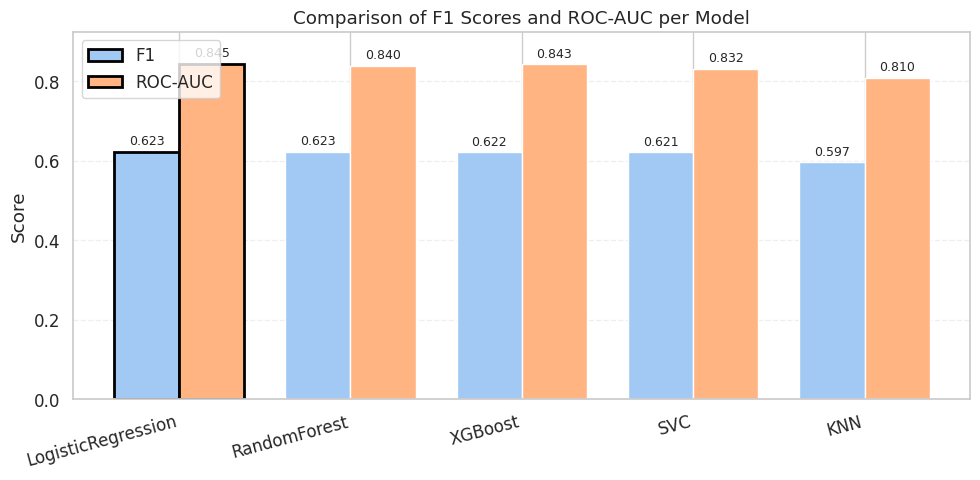


=== Best Model (based on F1) ===


,Model,F1,ROC-AUC,Accuracy,Precision,Recall,AP,Best_Params
0,LogisticRegression,0.623236,0.844764,0.752496,0.521818,0.773585,0.640393,"{'classifier__C': 1, 'classifier__solver': 'lb..."


In [49]:
# =====================================
# 7. Visual Comparison (F1 vs ROC-AUC)
# =====================================
plot_df = results_df.reset_index(drop=True).copy()
labels   = plot_df["Model"].tolist()
f1_vals  = plot_df["F1"].values
roc_vals = plot_df["ROC-AUC"].values

x = np.arange(len(labels))
w = 0.38
fig, ax = plt.subplots(figsize=(10, 5))
bars_f1  = ax.bar(x - w/2, f1_vals, width=w, label="F1")
bars_roc = ax.bar(x + w/2, roc_vals, width=w, label="ROC-AUC")

best_idx = int(np.argmax(f1_vals))
for b in (bars_f1[best_idx], bars_roc[best_idx]):
    b.set_edgecolor("black"); b.set_linewidth(2)

def annotate(bars, fmt="{:.3f}"):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, fmt.format(h),
                ha="center", va="bottom", fontsize=9)

annotate(bars_f1); annotate(bars_roc)
ax.set_ylabel("Score")
ax.set_title("Comparison of F1 Scores and ROC-AUC per Model")
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=15, ha="right")
ax.set_ylim(0, max(np.max(f1_vals), np.max(roc_vals)) + 0.08)
ax.legend(loc="upper left"); ax.grid(axis="y", linestyle="--", alpha=0.3)
save_fig("charts/compare_f1_roc.png")

print("\n=== Best Model (based on F1) ===")
display(plot_df.loc[[best_idx], ["Model","F1","ROC-AUC","Accuracy","Precision","Recall","AP","Best_Params"]])


In [51]:
# ============================
# 8. Deep Dive Best Model Eval
# ============================
best_name = plot_df.loc[best_idx, "Model"]
best_model = best_objects[best_name]
print(f"\n>> Best model: {best_name}")

# Predict test
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]


>> Best model: LogisticRegression


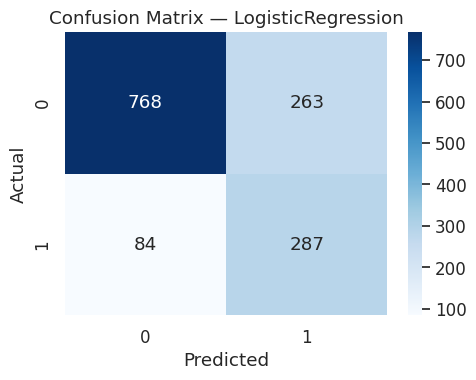

In [52]:
# 8.1 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted"); plt.ylabel("Actual")
save_fig(f"charts/cm_{best_name}.png")

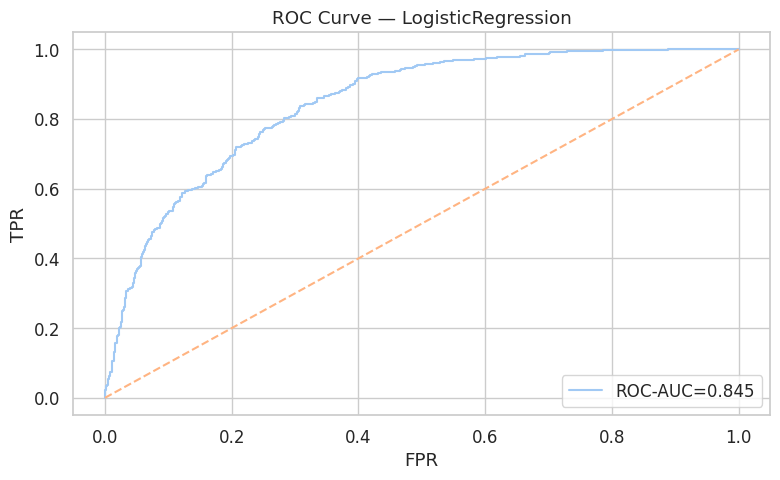

In [53]:
# 8.2 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"ROC Curve — {best_name}")
plt.legend(loc="lower right")
save_fig(f"charts/roc_{best_name}.png")

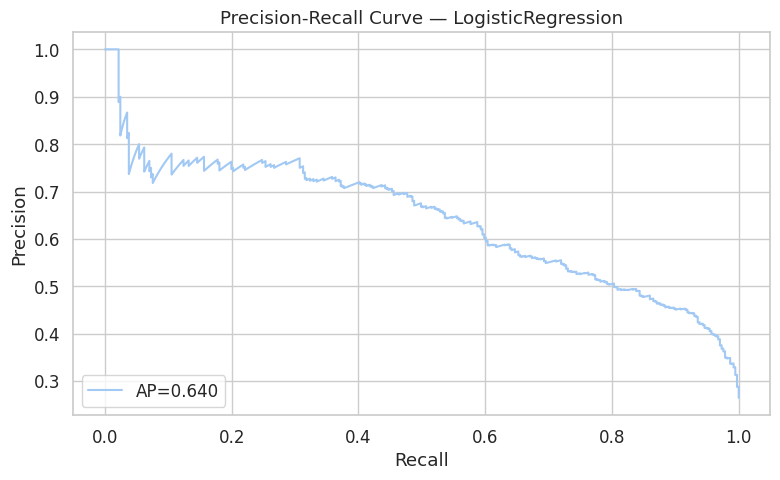

In [54]:
# 8.3 Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve — {best_name}")
plt.legend(loc="lower left")
save_fig(f"charts/pr_{best_name}.png")

In [55]:
# 8.4 Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))


Classification Report:
              precision    recall  f1-score   support

           0      0.901     0.745     0.816      1031
           1      0.522     0.774     0.623       371

    accuracy                          0.752      1402
   macro avg      0.712     0.759     0.719      1402
weighted avg      0.801     0.752     0.765      1402



In [56]:
# =======================================
# 9. (Opsional) Business Recommendations
# =======================================
RECO_TEMPLATE = f"""
Business Recommendations (based on the model) {best_name} & EDA):
1) Focus retention on high-risk customers (top decile probability of churn).
2) Offer longer contracts (discount bundling) for high-risk monthly contracts.
3) Monitor short-tenure customers with high monthly costs (3-month introductory promotion).
4) Conduct a phased outbound campaign: educate on features, ease of payment, loyalty benefits.
"""

print(RECO_TEMPLATE.strip())

Business Recommendations (based on the model) LogisticRegression & EDA):
1) Focus retention on high-risk customers (top decile probability of churn).
2) Offer longer contracts (discount bundling) for high-risk monthly contracts.
3) Monitor short-tenure customers with high monthly costs (3-month introductory promotion).
4) Conduct a phased outbound campaign: educate on features, ease of payment, loyalty benefits.


In [58]:
# ======================
# 10. How to Reproduce?
# ======================
HOWTO = """
How to run (Colab):
1) Upload ‘customer_churn_data.csv’ to /content or mount Google Drive.
2) Run all cells from the top (Runtime > Run all).
3) View the output:
   - results.csv → summary of metrics for each model
   - charts/*.png → EDA & evaluation visuals
"""
print(HOWTO.strip())

How to run (Colab):
1) Upload ‘customer_churn_data.csv’ to /content or mount Google Drive.
2) Run all cells from the top (Runtime > Run all).
3) View the output:
   - results.csv → summary of metrics for each model
   - charts/*.png → EDA & evaluation visuals
